**UTS MACHINE LEARNING**

**WINE QUALITY**

**NAMA**: Ilham Akbar

**NIM**: 4112322005

**DATE**: 16 April 2025

In [13]:
# 1. Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Langkah pertama adalah mengimpor semua library yang akan digunakan. Di sini, kita memakai pustaka populer untuk manipulasi data (pandas, numpy), visualisasi (matplotlib, seaborn), preprocessing dan evaluasi (sklearn), serta model machine learning XGBoost (xgboost). Kita juga gunakan scipy.stats untuk keperluan hyperparameter tuning.

In [2]:
# 2. Load data training dan testing
train_df = pd.read_excel("/content/data_training.xlsx")
test_df = pd.read_excel("/content/data_testing.xlsx")

Dataset training dan testing dibaca dari file Excel menggunakan pandas. Dataset training berisi fitur dan target (quality), sedangkan dataset testing hanya berisi fitur dan id.

In [3]:
# 3. Cek data dan info
print("Training Data Info:")
print(train_df.info())
print(train_df.head())

print("\nTesting Data Info:")
print(test_df.info())
print(test_df.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    857 non-null    int64  
 1   fixed acidity         857 non-null    float64
 2   volatile acidity      857 non-null    float64
 3   citric acid           857 non-null    float64
 4   residual sugar        857 non-null    float64
 5   chlorides             857 non-null    float64
 6   free sulfur dioxide   857 non-null    float64
 7   total sulfur dioxide  857 non-null    float64
 8   density               857 non-null    float64
 9   pH                    857 non-null    float64
 10  sulphates             857 non-null    float64
 11  alcohol               857 non-null    float64
 12  quality               857 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 87.2 KB
None
     id  fixed acidity  volatile acidity  citric acid

Kita melihat struktur data, tipe data setiap kolom, dan beberapa baris awal. Ini penting untuk memastikan data terbaca dengan benar dan memahami bentuk umum data sebelum diproses.

Data training berisi 857 baris dan 13 kolom, termasuk id dan quality.

Data testing memiliki 286 baris dan juga 13 kolom, tapi tidak seharusnya ada quality. Ini perlu dikonfirmasi (mungkin dummy atau placeholder).

In [4]:
# 4. Cek missing values
print("\nMissing values in training:", train_df.isnull().sum().sum())
print("Missing values in testing:", test_df.isnull().sum().sum())


Missing values in training: 0
Missing values in testing: 0


Kita memeriksa apakah terdapat nilai yang hilang (missing values) di dataset. Jika ada, perlu dilakukan penanganan seperti imputasi atau penghapusan data.

Di kasus ini, tidak ditemukan nilai kosong, sehingga data dapat langsung digunakan tanpa proses imputasi.

In [5]:
# 5. Pisahkan fitur dan target
X = train_df.drop(['quality', 'id'], axis=1)
y = train_df['quality']
X_test = test_df.drop(['id', 'quality'], axis=1)
test_id = test_df['id']

# Encode target
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Kita memisahkan kolom fitur (X) dan target (y) dari data training. Kolom id juga dipisahkan karena bukan fitur input.

Dari data testing, kita ambil id untuk nanti digunakan di hasil prediksi.

In [6]:
# 6. Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

Target quality dikodekan menjadi angka 0, 1, ..., n dengan LabelEncoder. Kemudian, kita menstandardisasi fitur agar memiliki distribusi normal (mean = 0, std = 1), yang membantu meningkatkan performa model.

LabelEncoder digunakan untuk mengubah label kualitas menjadi bentuk numerik yang bisa diproses model.

StandardScaler digunakan agar setiap fitur memiliki skala yang seragam (mean=0, std=1), penting untuk algoritma yang sensitif terhadap skala.

In [7]:
# 7. Split data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

Data dibagi menjadi 80% untuk pelatihan dan 20% untuk validasi, sambil mempertahankan distribusi label yang seimbang dengan stratify.

In [8]:
# 8. Feature Selection dengan XGBoost
selector_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
selector_model.fit(X_train, y_train)

# Pilih fitur penting (threshold = 'median' memilih setengah fitur paling penting)
selector = SelectFromModel(selector_model, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost digunakan untuk mengidentifikasi fitur-fitur paling penting. Fitur yang memiliki kontribusi di bawah median akan dibuang.

Ini membantu menyederhanakan model, mengurangi overfitting, dan mempercepat pelatihan.

In [9]:
# 9. Hyperparameter tuning dengan RandomizedSearchCV
xgb = XGBClassifier(objective='multi:softmax', num_class=len(encoder.classes_),
                    random_state=42, use_label_encoder=False, eval_metric='mlogloss')

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,
                                   n_iter=50, scoring='f1_macro', cv=5,
                                   random_state=42, n_jobs=-1, verbose=1)

random_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdfb544f5d0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fdfb53ff9d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe0221983d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdfb5124a10>},
                   random_state=42, scoring='f1_macro', verbose=1)

Untuk mendapatkan performa terbaik dari model XGBoost, kita lakukan pencarian kombinasi hyperparameter terbaik menggunakan RandomizedSearchCV.

Metode ini mencoba 50 kombinasi secara acak dari parameter-parameter yang didefinisikan. Metode ini lebih efisien dari GridSearch untuk ruang parameter yang besar.

<Figure size 800x600 with 0 Axes>

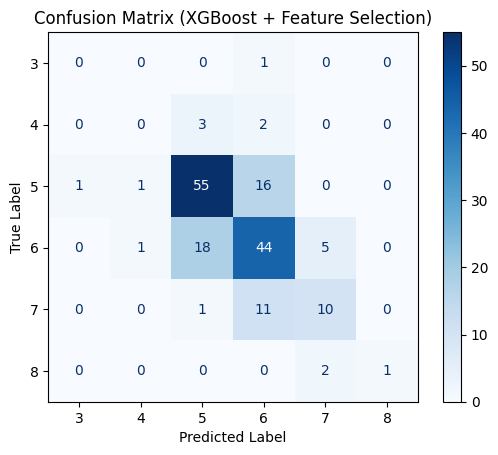

          Predicted 3  Predicted 4  Predicted 5  Predicted 6  Predicted 7  \
Actual 3            0            0            0            1            0   
Actual 4            0            0            3            2            0   
Actual 5            1            1           55           16            0   
Actual 6            0            1           18           44            5   
Actual 7            0            0            1           11           10   
Actual 8            0            0            0            0            2   

          Predicted 8  
Actual 3            0  
Actual 4            0  
Actual 5            0  
Actual 6            0  
Actual 7            0  
Actual 8            1  


In [15]:
# 10. Visualisasi dan evaluasi Confusion matrix
# Membuat confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = encoder.classes_

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (XGBoost + Feature Selection)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

decoded_y_val = encoder.inverse_transform(y_val)
decoded_y_pred = encoder.inverse_transform(y_pred)
cm_labeled = confusion_matrix(decoded_y_val, decoded_y_pred)

# Buat DataFrame agar lebih rapi
cm_df = pd.DataFrame(cm_labeled,
                     index=[f"Actual {label}" for label in encoder.classes_],
                     columns=[f"Predicted {label}" for label in encoder.classes_])
print(cm_df)

Langkah ini bertujuan untuk mengevaluasi kinerja model XGBoost melalui confusion matrix, yaitu tabel yang membandingkan antara label sebenarnya (actual) dengan hasil prediksi model (predicted). Pertama, model membuat confusion matrix dari data validasi (y_val dan y_pred) dalam bentuk numerik. Karena label target sebelumnya telah dienkode dengan LabelEncoder, label integer ini kemudian dikembalikan ke label asli (misalnya 3, 4, 5, dst) agar lebih mudah dipahami.

Confusion matrix divisualisasikan dalam bentuk heatmap menggunakan ConfusionMatrixDisplay, dengan pewarnaan biru untuk memperjelas intensitas jumlah prediksi. Visualisasi ini menunjukkan berapa kali model memprediksi dengan benar (terlihat pada diagonal) dan berapa kali model melakukan kesalahan prediksi (terlihat pada bagian di luar diagonal).

Selain visualisasi, confusion matrix juga ditampilkan dalam format tabel DataFrame. Tabel ini menunjukkan bahwa model mampu memprediksi kelas 5 dengan sangat baik (55 prediksi benar), namun cukup sering melakukan kesalahan pada kelas yang berdekatan seperti kelas 5 diprediksi sebagai 6 (16 kali), dan sebaliknya kelas 6 diprediksi sebagai 5 (18 kali). Sementara itu, kelas dengan jumlah data lebih sedikit seperti kelas 3, 4, dan 8 memiliki akurasi yang sangat rendah, bahkan ada yang tidak terprediksi sama sekali dengan benar. Hal ini menunjukkan bahwa model bekerja cukup baik pada kelas mayoritas, namun masih kesulitan membedakan kelas minoritas atau yang jumlahnya terbatas.

In [10]:
# 11. Evaluasi model terbaik
print("\nBest Parameters from RandomizedSearchCV:", random_search.best_params_)

best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_val_selected)

print("\nClassification Report (XGBoost + Feature Selection):")
print(classification_report(y_val, y_pred))


Best Parameters from RandomizedSearchCV: {'colsample_bytree': np.float64(0.9395655297064336), 'learning_rate': np.float64(0.22651885634946198), 'max_depth': 9, 'n_estimators': 241, 'subsample': np.float64(0.7975182385457563)}

Classification Report (XGBoost + Feature Selection):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.71      0.75      0.73        73
           3       0.59      0.65      0.62        68
           4       0.59      0.45      0.51        22
           5       1.00      0.33      0.50         3

    accuracy                           0.64       172
   macro avg       0.48      0.36      0.39       172
weighted avg       0.63      0.64      0.63       172



Setelah tuning selesai, kita ambil model terbaik dan uji pada data validasi. Kita menilai performa model berdasarkan classification report (precision, recall, f1-score). Hasil model ini menunjukkan akurasi sekitar 64%, yang bisa dianggap cukup baik tergantung kompleksitas data dan distribusi kelas.

Interpretasi:

*   Model cenderung bekerja baik pada kelas mayoritas (kelas 2 dan 3).
*   Kelas minoritas (0, 1, 5) memiliki skor yang rendah. Ini bisa disebabkan ketidakseimbangan data.
*   Perlu pertimbangan seperti SMOTE atau class_weight jika ingin meningkatkan skor pada kelas kecil.

In [11]:
# 12. Prediksi pada data testing
xgb_test_pred = best_xgb_model.predict(X_test_selected)
xgb_test_pred = encoder.inverse_transform(xgb_test_pred)

Prediksi dilakukan pada data uji, dan label dikembalikan ke bentuk aslinya (skala 0–10) dengan inverse_transform.

Model digunakan untuk memprediksi kualitas anggur di data testing. Karena sebelumnya kita encoding label dengan LabelEncoder, kita kembalikan hasil prediksi ke label aslinya (angka kualitas yang sebenarnya).

In [12]:
# 13. Simpan hasil prediksi
xgb_result = pd.DataFrame({
    "id": test_id,
    "quality": xgb_test_pred
})

xgb_result.to_csv("hasil_prediksi_XGBOOST_FS.csv", index=False)
print("\nPrediksi berhasil disimpan ke hasil_prediksi_XGBOOST_FS.csv")


Prediksi berhasil disimpan ke hasil_prediksi_XGBOOST_FS.csv


Hasil akhir disimpan ke dalam file CSV dengan format Id dan Quality